# 4. Stitch outputs together
- Once you have fitted the weak, medium and dense diads, stitch them all together, and apply the Ne correction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib
import DiadFit as pf
pf.__version__

'1.0.5'

In [2]:
# Load in settings, paths, file extensions etc. that you saved in step 1
meta_path, spectra_path, spectra_filetype, prefix, str_prefix, spectra_file_ext, meta_file_ext, TruPower=pf.get_settings()

## Load in specra, and combine

In [3]:
import os
df2=pf.merge_fit_files(path=os.getcwd())
df2.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad1_PDF_Model,Diad2_PDF_Model,Standard
0,L84-FI39-FI#1,103.306383,0.016512,1285.509965,0.015307,674.404144,1285.509965,1001.262322,0.582484,12.137361,...,1.113333,0.161411,0.001727,1.037500,1.034398,0.035335,0.000752,PseudoVoigtModel,PseudoVoigtModel,No
1,L84-FI39-FI#2_CRR_DiadFit,103.273128,0.184558,1285.585483,0.120444,80.773289,1285.585483,113.609498,0.660670,12.537358,...,1.428884,0.190463,0.016359,1.413636,1.531365,0.293923,0.003803,PseudoVoigtModel,PseudoVoigtModel,No


## First, get the metadata for this day

In [4]:
# Put the common string you can in all your Ne lines here
diad_meta=pf.get_files(path=meta_path,
file_ext=meta_file_ext, exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Ne', 'Cap','window','Video', 'nodiad','diad','Series','no_diad','diad','Series','unquant','map','Series','broad'],
 sort=True)
diad_meta[0]

'01 L84-FI39-IMG5x.txt'

## Now get all the important information out of the metadata files

In [5]:
# This will only work for WITEC - for other vendors, you might have to use the file datastamp. See the HORIBA example
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=diad_meta, prefix=prefix, str_prefix=str_prefix,
trupower=TruPower)
meta.head()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 732.78it/s]

Done


,filename,date,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,L84-FI39-FI#1.txt,"October 26, 2022\n",October,26.0,12.004,45.0,5.0,50.0,"['0h', '3m', '46s']",11:05:33 AM\n,39933.0,1325.004
1,L84-FI39-FI#2.txt,"October 26, 2022\n",October,26.0,12.041,45.0,5.0,50.0,"['0h', '3m', '46s']",11:39:49 AM\n,41989.0,1325.004


## Then get a simple file name you can stitch with the spectra

In [6]:
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_ext=meta_file_ext)
# Checks they are all unique
file_m[0]

good job, no duplicate file names


'L84-FI39-FI#1'

In [7]:
for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m

array(['L84-FI39-FI#1', 'L84-FI39-FI#2'], dtype=object)

## Now get filename from spectra into same form as metadata

In [8]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(
    names=df2['filename'].reset_index(drop=True),
   file_ext=spectra_file_ext)

# Remove the cosmic rays, as doesnt have it in the metatdata
file_s = np.char.replace(file_s.astype(str), "_CRR_DiadFit", "")
print(file_s[0])

good job, no duplicate file names
L84-FI39-FI#1


In [9]:
for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

array(['L84-FI39-FI#1', 'L84-FI39-FI#2'], dtype='<U13')

In [10]:
# Combining them together, if the form above matches, e.g. checking one doesnt have a suffix and the other one does

meta['filename']=file_m
df2['filename']=file_s
df_combo=pd.merge(df2, meta, on='filename').reset_index(drop=True)
df_combo.head()

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Month,Day,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center
0,L84-FI39-FI#1,103.306383,0.016512,1285.509965,0.015307,674.404144,1285.509965,1001.262322,0.582484,12.137361,...,October,26.0,12.004,45.0,5.0,50.0,"['0h', '3m', '46s']",11:05:33 AM\n,39933.0,1325.004
1,L84-FI39-FI#2,103.273128,0.184558,1285.585483,0.120444,80.773289,1285.585483,113.609498,0.660670,12.537358,...,October,26.0,12.041,45.0,5.0,50.0,"['0h', '3m', '46s']",11:39:49 AM\n,41989.0,1325.004


## If you have secondary phases, now is the time to merge those in

In [11]:
df_combo_sec_phase=pf.merge_in_carb_SO2(
df_combo=df_combo, file1_name='Carb_Peak_fits.xlsx', file2_name='SO2_Peak_fits.xlsx', 
prefix=prefix, str_prefix=str_prefix, file_ext=spectra_file_ext)
#df_combo_sec_phase.to_excel('FI_fitting_w_sec_phases.xlsx', index=False)

Made a df!
good job, no duplicate file names


## If you have SO2, now is the time to calculate the molar proportion of SO2

In [12]:
if 'Peak_Area_SO2' in df_combo_sec_phase:
    

        SO2_mol_ratio=pf.calculate_SO2_CO2_ratio(SO2_area=df_combo_sec_phase['Peak_Area_SO2'], 
        diad1_area=df_combo_sec_phase['Diad1_Voigt_Area'], diad2_area=df_combo_sec_phase['Diad2_Voigt_Area'], 
                SO2_cross_sec=5.3, diad1_cross_sec=0.89, diad2_cross_sec=1.4)
        

        df_combo_sec_phase['SO2_mol_ratio']=SO2_mol_ratio

## Now we calculate the density using the UC Berkeley Densimeter. 
- If you have your own densimeter, I am happy to add a function for it if you email me (penny_wieser@berkeley.edu)
- This particular function propagates the uncertainty on 1) The neon line correction model 2) the peak fits of the diads themselves 3) The densimeter. 

In [13]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

7.388552147880034e-08


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
0,L84-FI39-FI#1,0.135643,0.007585,0.006529,0.00386,103.092582,0.016478,0.000007,0.016512,12.004,...,NaN,NaN,NaN,NaN,NaN,NaN,39933.0,0.997930,0.997930,0.997930
1,L84-FI39-FI#2,0.121354,0.073076,0.072976,0.00383,103.056520,0.184171,0.000008,0.184558,12.041,...,907.477608,187.874333,Spline,2.817751,0.169707,0.068317,41989.0,0.997903,0.997902,0.997903


In [14]:
df=pf.calculate_density_ucb(df_combo=df_combo_sec_phase,
  Ne_pickle_str='Neon_corr_model.pkl',  temp='SupCrit', CI_split=0.67, CI_neon=0.67)
df.head()

7.388552147880034e-08


,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values
0,L84-FI39-FI#1,0.135643,0.007585,0.006529,0.00386,103.092582,0.016478,0.000007,0.016512,12.004,...,NaN,NaN,NaN,NaN,NaN,NaN,39933.0,0.997930,0.997930,0.997930
1,L84-FI39-FI#2,0.121354,0.073076,0.072976,0.00383,103.056520,0.184171,0.000008,0.184558,12.041,...,907.477608,187.874333,Spline,2.817751,0.169707,0.068317,41989.0,0.997903,0.997902,0.997903


### This cell saves the merged together dataframe with the folder name and the date you fitted it

In [15]:

from datetime import date
today = date.today()
today_str = today.strftime("%Y-%m-%d")
sorted_df = df.sort_values('sec since midnight')
date=meta['date'].iloc[0].replace('\n', '')
name='Raman_session_'+date+'_fitted_'+today_str+'.xlsx'
print(name)
# sorted_df=sorted_df[~(sorted_df['Corrected_Splitting']>106)]
sorted_df.to_excel(name)

Raman_session_October 26, 2022_fitted_2025-01-24.xlsx


## This helps visualize the errors on each spectra 

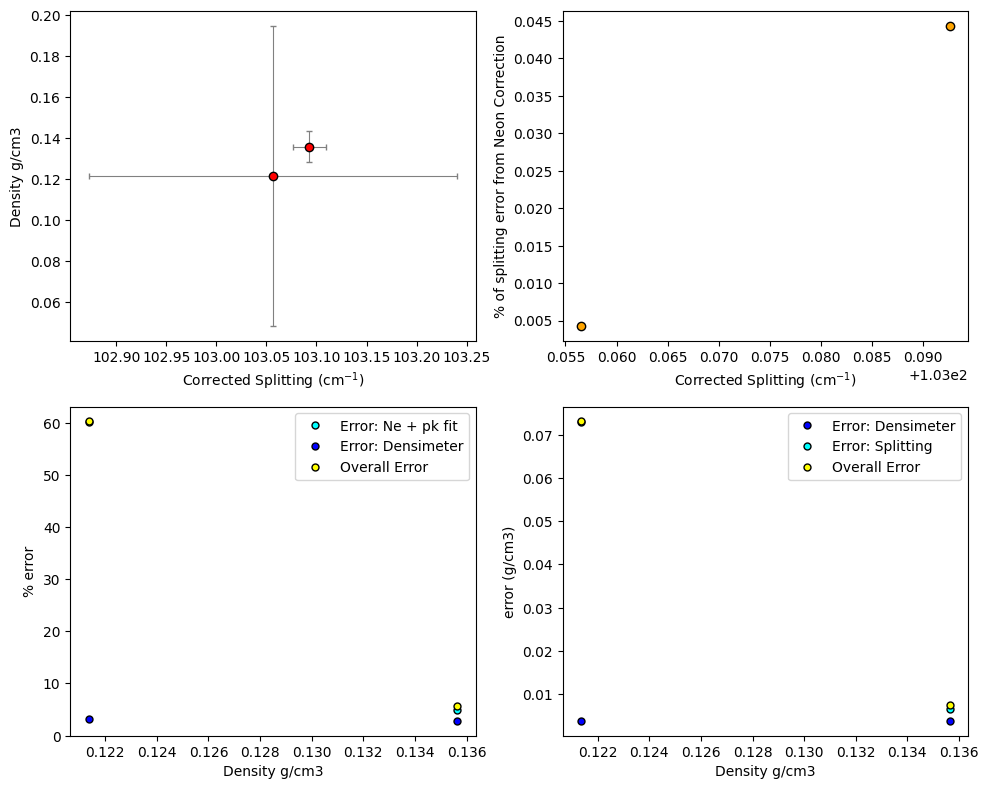

In [16]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
df=sorted_df.loc[(sorted_df['Density g/cm3']>0) & (sorted_df['Standard']!='Yes')]

ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

ax2.plot(df['Corrected_Splitting'], 
100*df['Corrected_Splitting_σ_Ne']/(df['Corrected_Splitting_σ_Ne']+df['Corrected_Splitting_σ_peak_fit']),
 'ok', mfc='orange')
ax2.set_ylabel('% of splitting error from Neon Correction')
ax2.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from Ne+peakfit)']/df['Density g/cm3'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')


ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from densimeter)']/df['Density g/cm3'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')

ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3']/df['Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax3.set_ylabel('% error')
ax3.set_xlabel('Density g/cm3')
ax3.legend()

ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from densimeter)'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from Ne+peakfit)'], 
'ok', mfc='cyan', ms=5, label='Error: Splitting')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax4.set_ylabel('error (g/cm3)')
ax4.set_xlabel('Density g/cm3')
ax4.legend()

fig.tight_layout()

## lets look at standards


Text(0, 0.5, 'Density g/cm3')

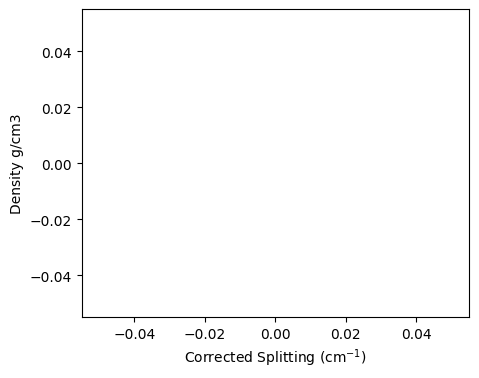

In [17]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5,4))
df=sorted_df.loc[ sorted_df['Standard']=='Yes']
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

In [18]:
df

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,power (mW),...,Peak_Area_Carb,Peak_Height_Carb,Model_name_y,Carb_Diad_Ratio,SO2_Diad_Ratio,SO2_mol_ratio,time,preferred_values,lower_values,upper_values


In [19]:
df.to_clipboard(excel=True,index=False)

## If you were analysing fluid inclusions, lets calculate their pressures
- This bit isn't valid for melt inclusion vapour bubbles. 

Text(0, 0.5, '# of FI')

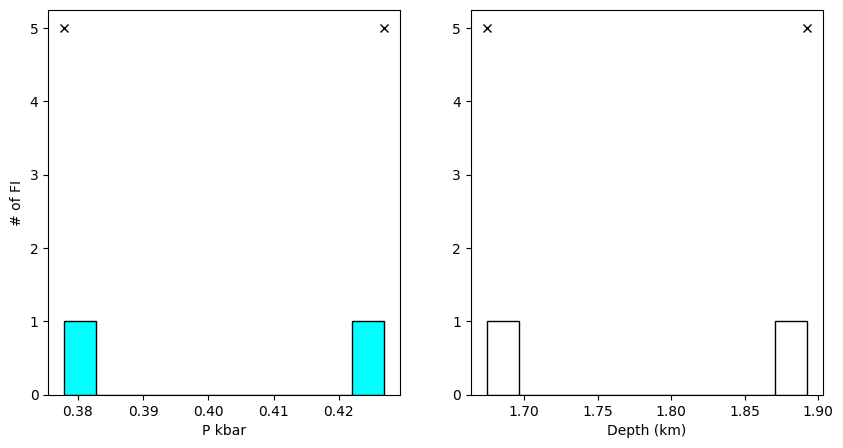

In [20]:
# Calculate pressure with a temperature estimate
Temp_C=1240
df=sorted_df.loc[(sorted_df['Density g/cm3']>0) & (sorted_df['Standard']!='Yes')]

Pressure_SW96=pf.calculate_P_for_rho_T(T_K=Temp_C+273.15,
                CO2_dens_gcm3=df['Density g/cm3'],
                 EOS='SW96')
# Calculate depth from a crustal density assumption
Depth=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'], 
                crust_dens_kgm3=2300)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(Pressure_SW96['P_kbar'], ec='k', fc='cyan', bins=10)
ax1.plot(Pressure_SW96['P_kbar'], Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.plot(Depth, Pressure_SW96['P_kbar']*0+5, 'xk')
ax2.hist(Depth, ec='k', fc='white', bins=10)
ax1.set_xlabel('P kbar')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of FI')

In [21]:
import os

if os.name=="posix":

    def mac_notification(title, subtitle, message):
        """
        Display a macOS notification with the default sound using AppleScript.
        
        Args:
        - title: Title of the notification.
        - subtitle: Subtitle of the notification.
        - message: Main message content of the notification.
        """
        os.system("""
                osascript -e 'display notification "{}" with title "{}" subtitle "{}" sound name "default"'
                """.format(message, title, subtitle))

    mac_notification("Notebook Completed", "VSCode", "Step4 Stitch outputs")

else:

    # %pip install winotify

    from winotify import Notification, audio

    toast= Notification(app_id="VSCode",title="Notebook completed",
                        msg="Step4 Stitch outputs is done!",
                        duration="short")
    toast.set_audio(audio.Mail,loop=False)
    toast.show()